In [2]:
import numpy as np 
import pandas as pd 
import os 
import random 
from tqdm import tqdm 
import torch 
import torch.nn as nn 
import json 
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer, AlbertTokenizer, AutoModelForSequenceClassification
import pickle
import ccxt # needed for processing chart data 
import pandas_ta as ta # needed for processing chart data 
from random import randrange # needed for random agent 

from lightgbm import LGBMClassifier 
from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor 
from tensorflow.keras.models import * 
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import * 

import time 
import random 
import math 
from sklearn.metrics import f1_score 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import mean_squared_error, mean_absolute_error

/usr/local/lib/python3.6/dist-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


In [3]:
df = pd.read_csv("4hours-v2/roberta.csv")
datetimes = df['datetime'].values 

train_idx, val_idx, test_idx, test_end_idx = -1,-1,-1, -1 

for i, d in enumerate(datetimes): 
    d = pd.to_datetime(d)
    if d.year == 2018 and d.month == 2 and d.day == 14 and d.hour == 16:
        train_idx = i
    elif d.year == 2021 and d.month == 6 and d.day == 16 and d.hour == 0:
        val_idx = i
    elif d.year == 2021 and d.month == 11 and d.day == 14 and d.hour == 20:
        test_idx = i 
    elif d.year == 2022 and d.month == 4 and d.day == 15 and d.hour == 20: 
        test_end_idx = i 
        
train_df = df.iloc[train_idx:val_idx] 
val_df = df.iloc[val_idx:test_idx] 
test_df = df.iloc[test_idx:test_end_idx+1] 

In [4]:
 train_df.shape, val_df.shape, test_df.shape

((7295, 37), (911, 37), (913, 37))

In [5]:
train_df.head()

,datetime,months,days,hours,high_delta,low_delta,sent_0,sent_1,sent_2,bop,...,low_change_2,close_change_2,volume_change_2,vwap_change_2,open_change_3,high_change_3,low_change_3,close_change_3,volume_change_3,vwap_change_3
1042,2018-02-14 16:00:00,2,14,16,0.027084,-0.005342,0.260585,0.383494,0.355921,-0.390696,...,1.047102,1.034990,1.404685,1.028708,1.071216,1.057505,1.053416,1.041622,1.348966,1.033794
1043,2018-02-14 20:00:00,2,14,20,0.027514,-0.015713,0.000000,0.000000,0.000000,0.727470,...,1.029707,1.012852,0.395766,1.011315,1.040796,1.062588,1.049386,1.058585,1.020059,1.033623
1044,2018-02-15 00:00:00,2,15,0,0.018743,-0.001721,0.000000,0.000000,0.000000,0.456793,...,1.014340,1.042992,1.114439,1.056137,1.058233,1.038503,1.042200,1.032851,0.607364,1.063009
1045,2018-02-15 04:00:00,2,15,4,0.011739,-0.044694,0.000000,0.000000,0.000000,0.846907,...,1.046790,1.038097,1.270071,1.061070,1.033634,1.044383,1.049073,1.061763,0.922304,1.066139
1046,2018-02-15 08:00:00,2,15,8,0.030319,-0.000685,0.000000,0.000000,0.000000,-0.439750,...,1.007532,0.992734,1.584201,1.008561,1.062605,1.045900,1.019756,1.012335,2.431200,1.060114


# High Model

In [7]:
input_columns = [] 
for col in train_df.columns:
    if col != 'high_delta' and col != 'datetime' and col != 'low_delta':
        input_columns.append(col)

X_train = train_df[input_columns].values  
Y_train = train_df['high_delta'].values

X_val = val_df[input_columns].values 
Y_val = val_df['high_delta'].values 

X_test = test_df[input_columns].values
Y_test = test_df['high_delta'].values

In [11]:
X_train = X_train.reshape((-1, 1, X_train.shape[-1])) 
X_val = X_val.reshape((-1, 1, X_val.shape[-1])) 
X_test = X_test.reshape((-1, 1, X_test.shape[-1]))

In [13]:
def build_model():
    inputs = Input((1, X_train.shape[2])) 
    bn = BatchNormalization()(inputs) 
    x = LSTM(64, return_sequences=True)(bn) 
    x = Dropout(0.1)(x) 
    x = LSTM(32, return_sequences=True)(x) 
    x = Dropout(0.1)(x) 
    x = LSTM(16)(x) 
    x = Dense(1, activation='linear')(x) 
    model = Model(inputs=inputs, outputs=x) 
    model.compile(loss='mse', optimizer='adam') 
    return model 

In [14]:
model = build_model()

In [15]:
model_path = 'EMNLP_High_LSTM.h5'
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 30) 
history = model.fit(X_train,
                    Y_train,
                    epochs = 100,
                    batch_size = 32,
                    validation_data = (X_val, Y_val),
                    callbacks = [checkpoint, early_stopping]) 


Epoch 1/100
228/228 [==============================] - 7s 10ms/step - loss: 1.5148e-04 - val_loss: 1.2738e-04

Epoch 00001: val_loss improved from inf to 0.00013, saving model to EMNLP_High_LSTM.h5
Epoch 2/100
228/228 [==============================] - 1s 4ms/step - loss: 1.4301e-04 - val_loss: 1.1736e-04

Epoch 00002: val_loss improved from 0.00013 to 0.00012, saving model to EMNLP_High_LSTM.h5
Epoch 3/100
228/228 [==============================] - 1s 5ms/step - loss: 1.4182e-04 - val_loss: 1.1866e-04

Epoch 00003: val_loss did not improve from 0.00012
Epoch 4/100
228/228 [==============================] - 1s 5ms/step - loss: 1.3823e-04 - val_loss: 1.2120e-04

Epoch 00004: val_loss did not improve from 0.00012
Epoch 5/100
228/228 [==============================] - 1s 5ms/step - loss: 1.3673e-04 - val_loss: 1.1934e-04

Epoch 00005: val_loss did not improve from 0.00012
Epoch 6/100
228/228 [==============================] - 1s 5ms/step - loss: 1.3731e-04 - val_loss: 1.1820e-04

Epoch 00

In [16]:
best_lstm = load_model('EMNLP_High_LSTM.h5')


In [20]:
pred = best_lstm.predict(X_test).flatten()

In [22]:
print("MSE = {}".format(mean_squared_error(Y_test, pred))) 
print("MAE = {}".format(mean_absolute_error(Y_test, pred)))  

MSE = 9.790281043728756e-05
MAE = 0.007278248381863806


<Figure size 432x288 with 0 Axes>

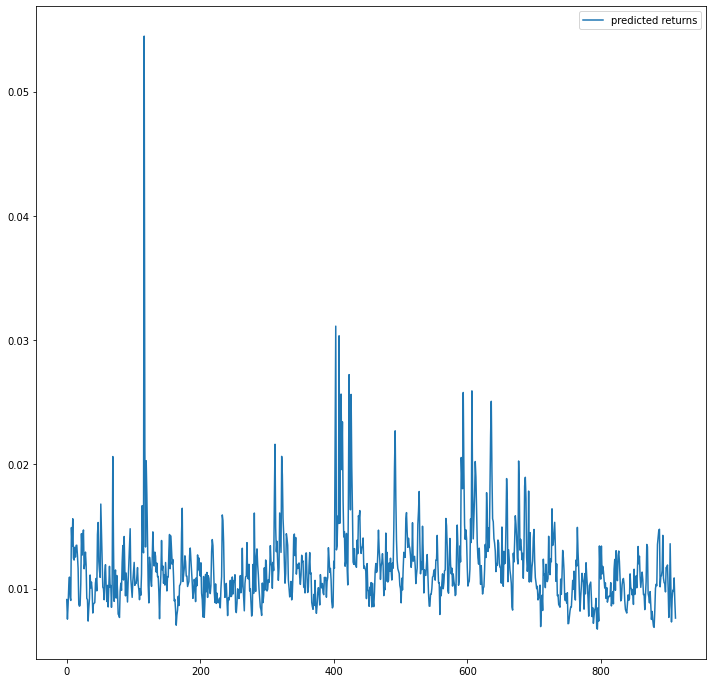

In [23]:
plt.figure() 
plt.figure(figsize=(12,12)) 
plt.plot(pred, label="predicted returns")
plt.legend()

<Figure size 432x288 with 0 Axes>

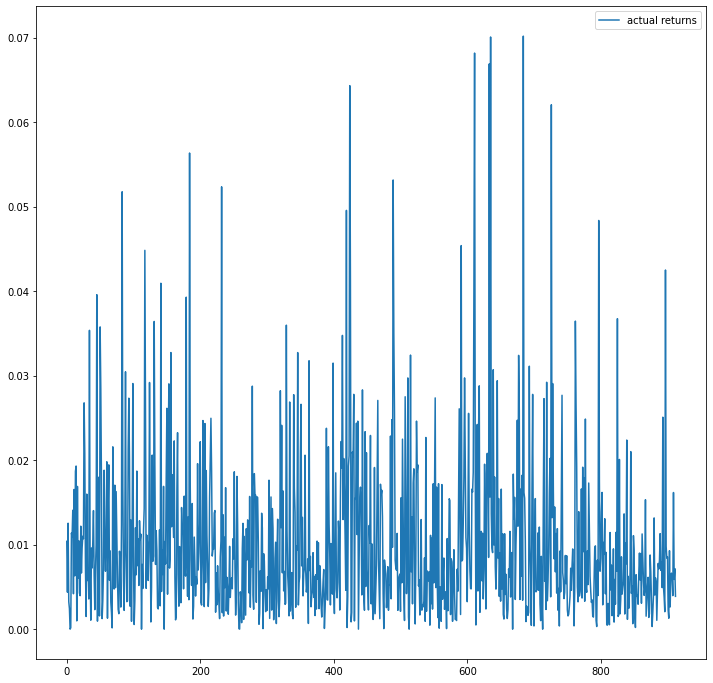

In [24]:
plt.figure() 
plt.figure(figsize=(12,12)) 
plt.plot(Y_test, label="actual returns")
plt.legend()

# Low Model

In [25]:
input_columns = [] 
for col in train_df.columns:
    if col != 'high_delta' and col != 'datetime' and col != 'low_delta':
        input_columns.append(col)

X_train = train_df[input_columns].values  
Y_train = train_df['low_delta'].values

X_val = val_df[input_columns].values 
Y_val = val_df['low_delta'].values 

X_test = test_df[input_columns].values
Y_test = test_df['low_delta'].values

In [26]:
X_train = X_train.reshape((-1, 1, X_train.shape[-1])) 
X_val = X_val.reshape((-1, 1, X_val.shape[-1])) 
X_test = X_test.reshape((-1, 1, X_test.shape[-1]))

In [27]:
model = build_model() 

In [28]:
model_path = 'EMNLP_Low_LSTM.h5'
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 30) 
history = model.fit(X_train,
                    Y_train,
                    epochs = 100,
                    batch_size = 32,
                    validation_data = (X_val, Y_val),
                    callbacks = [checkpoint, early_stopping]) 


Epoch 1/100
228/228 [==============================] - 7s 10ms/step - loss: 1.8914e-04 - val_loss: 1.2645e-04

Epoch 00001: val_loss improved from inf to 0.00013, saving model to EMNLP_Low_LSTM.h5
Epoch 2/100
228/228 [==============================] - 1s 5ms/step - loss: 1.7943e-04 - val_loss: 1.2836e-04

Epoch 00002: val_loss did not improve from 0.00013
Epoch 3/100
228/228 [==============================] - 1s 5ms/step - loss: 1.7467e-04 - val_loss: 1.2552e-04

Epoch 00003: val_loss improved from 0.00013 to 0.00013, saving model to EMNLP_Low_LSTM.h5
Epoch 4/100
228/228 [==============================] - 1s 5ms/step - loss: 1.7409e-04 - val_loss: 1.3112e-04

Epoch 00004: val_loss did not improve from 0.00013
Epoch 5/100
228/228 [==============================] - 1s 5ms/step - loss: 1.7332e-04 - val_loss: 1.3319e-04

Epoch 00005: val_loss did not improve from 0.00013
Epoch 6/100
228/228 [==============================] - 1s 5ms/step - loss: 1.7138e-04 - val_loss: 1.3416e-04

Epoch 0000

In [29]:
best_lstm = load_model('EMNLP_Low_LSTM.h5')
pred = best_lstm.predict(X_test).flatten() 

In [30]:
print("MSE = {}".format(mean_squared_error(Y_test, pred))) 
print("MAE = {}".format(mean_absolute_error(Y_test, pred)))  

MSE = 0.00013391467158051874
MAE = 0.007674431173279254


<Figure size 432x288 with 0 Axes>

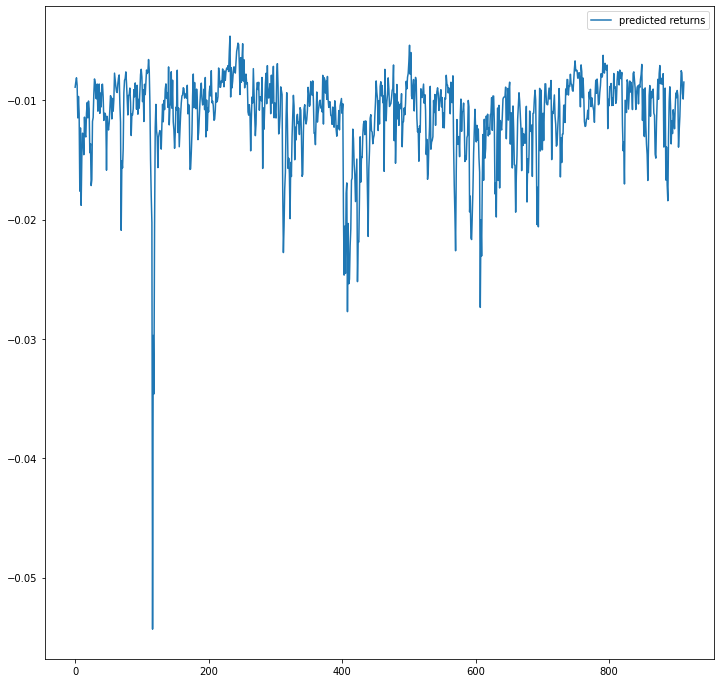

In [31]:
plt.figure() 
plt.figure(figsize=(12,12)) 
plt.plot(pred, label="predicted returns")
plt.legend()

<Figure size 432x288 with 0 Axes>

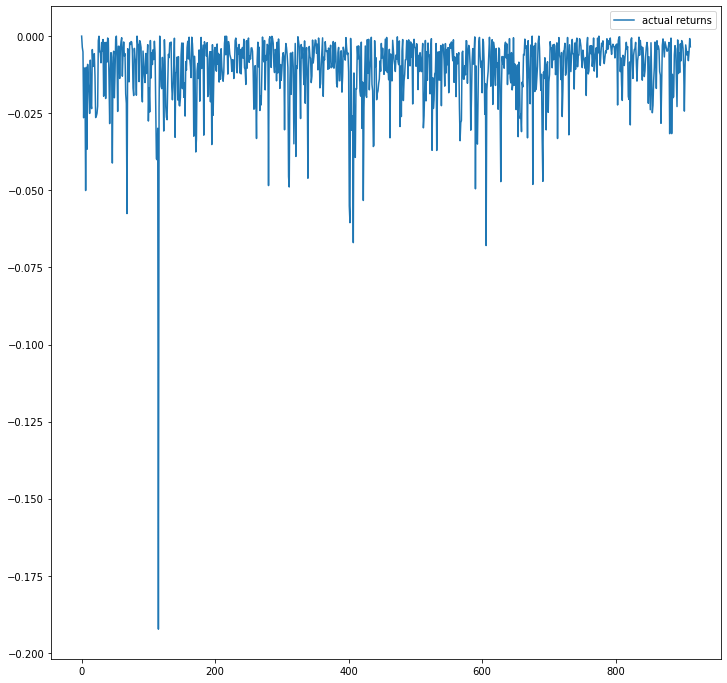

In [32]:
plt.figure() 
plt.figure(figsize=(12,12)) 
plt.plot(Y_test, label="actual returns")
plt.legend()